In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.utils import shuffle

from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
    Add, AveragePooling2D, Flatten, Dense, MaxPooling2D, Activation
from tensorflow.keras.models import Model
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
#Reading and Shuffling csv that contain filenames and label
df1 = pd.read_csv("/content/drive/Shareddrives/A&D co./BD/Database/labels_new.csv")
df2 = shuffle(df1, random_state=15)
df2.reset_index(inplace=True, drop=True)

In [ ]:
#Constants
num_classes = 3
epochs = 50
IMAGE_SHAPE = (64, 64, 3)
model_name = "ResNet34V2_"
data_dir = "/content/drive/Shareddrives/A&D co./BD/Database/Total_masks"
checkpoint_filepath = "/content/drive/Shareddrives/A&D co./BD/Database/results/ResNet34/"
#resnet34 layers
repetitions = [3,4,6,3]

# **Plotting function of Confusion Matrix**


In [ ]:
def plot_cm(y_true, y_pred,t, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '%.1f%%\n%d' % (0, 0)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    map = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    a = map.get_figure()
    a.savefig(checkpoint_filepath + model_name + str(batch_sizes[t])+"_"+ str(val_acc[t])+".png")

[Proposed residual block is created based on this research](https://arxiv.org/pdf/1603.05027v2.pdf)

# **ResNet Model**


In [ ]:
def bn_relu(input):
    norm = BatchNormalization()(input)
    return Activation("relu")(norm)


def bn_relu_conv(filters, kernel_size, strides=(1, 1)):
    def f(input):
        activation = bn_relu(input)
        return Conv2D(filters=filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding="same")(activation)
    return f


def res_block(input, filters, layer, block):
    init_strides = (1, 1)
    shortcut = input
    not_first_layer = (layer != 0 and block == 0)
    if block == 0 and layer == 0:
        conv1 = Conv2D(filters=filters,
                       kernel_size=(3, 3),
                       strides=init_strides,
                       padding="same")(input)
    else:
        conv1 = bn_relu_conv(filters=filters,
                             kernel_size=(3, 3),
                             strides=(1 if not not_first_layer else 2))(input)

    residual = bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
    input_shape = K.int_shape(input)
    res_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / res_shape[1]))
    stride_height = int(round(input_shape[2] / res_shape[2]))

    if not_first_layer:
        shortcut = Conv2D(filters=res_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid")(input)

    return Add()([shortcut, residual])


def ResNet(im_shape, repetitions):
    inputs = Input(shape=im_shape)
    num_filters = 64

    conv0 = Conv2D(kernel_size=(7, 7),
                   strides=(2, 2),
                   filters=num_filters,
                   padding="same")(inputs)
    activation0 = bn_relu(conv0)
    r = MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                     padding="same")(activation0)

    for i in range(len(repetitions)):
        num_blocks = repetitions[i]
        for j in range(num_blocks):
            r = res_block(
                r, layer=i, block=j, filters=num_filters)
        num_filters *= 2

    activation1 = bn_relu(r)
    block_shape = K.int_shape(activation1)
    pool1 = AveragePooling2D(pool_size=(block_shape[1], block_shape[2]),
                             strides=(1, 1))(activation1)
    fc = Flatten()(pool1)
    outputs = Dense(3, activation='softmax')(fc)

    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


#**Training with Hypertuning**



In [ ]:
image_generator  = ImageDataGenerator()     # make the training dataset generator
batch_sizes = [32,64,128]
training_data, validate_data, testing_data = np.split(df1.sample(frac=1, random_state=15), [int(.65*len(df1)), int(.8*len(df1))])

val_acc = []

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
for i in range(len(batch_sizes)):
  batch_size = batch_sizes[i] 
  train_generator  = image_generator.flow_from_dataframe(training_data,directory = data_dir, batch_size=batch_size,
                                                        x_col = "filename", y_col = "label", target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        class_mode = "categorical", shuffle=True)

  validation_generator = image_generator.flow_from_dataframe(validate_data,directory = data_dir, batch_size=batch_size, 
                                                        x_col = "filename", y_col = "label", target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                    class_mode = "categorical", shuffle=True)
  
  model = ResNet(IMAGE_SHAPE,repetitions)    
  steps_epoch = np.ceil(train_generator.samples/batch_size)
  steps_val = np.ceil(validation_generator.samples/batch_size)
  history = model.fit(train_generator, steps_per_epoch = steps_epoch,
                              validation_data=validation_generator, validation_steps= steps_val, 
                            epochs=epochs, verbose=1, callbacks = [checkpoint])
  
  val_acc.append(np.max(history.history['val_accuracy']))
  
  d = {'validation loss':history.history['val_loss'],'validation accuracy':history.history['val_accuracy'], 'epochs':list(range(1,epochs+1))}
  data =  pd.DataFrame(d)
  data.to_csv( checkpoint_filepath+ model_name+str(batch_sizes[i])+"_"+ str(val_acc[i])+'.csv', index=False)


t = val_acc.index(max(val_acc))  
print('The best validation accuracy of ' + str(val_acc[t]))
print('The best batch size ' + str(batch_sizes[t]))


Found 3473 validated image filenames belonging to 3 classes.
Found 802 validated image filenames belonging to 3 classes.
Epoch 1/50
109/109 [==============================] - 945s 9s/step - loss: 0.5944 - accuracy: 0.7590 - auc: 0.9058 - val_loss: 2.8621 - val_accuracy: 0.3840 - val_auc: 0.5551
Epoch 2/50
109/109 [==============================] - 22s 198ms/step - loss: 0.4027 - accuracy: 0.8425 - auc: 0.9557 - val_loss: 1.0212 - val_accuracy: 0.6845 - val_auc: 0.8569
Epoch 3/50
109/109 [==============================] - 22s 206ms/step - loss: 0.2993 - accuracy: 0.8900 - auc: 0.9745 - val_loss: 0.6698 - val_accuracy: 0.7805 - val_auc: 0.9255
Epoch 4/50
109/109 [==============================] - 21s 197ms/step - loss: 0.2514 - accuracy: 0.9021 - auc: 0.9824 - val_loss: 0.5760 - val_accuracy: 0.8367 - val_auc: 0.9415
Epoch 5/50
109/109 [==============================] - 21s 189ms/step - loss: 0.1767 - accuracy: 0.9346 - auc: 0.9906 - val_loss: 0.8198 - val_accuracy: 0.7594 - val_auc: 0.9

#**Testing the trained model**

In [ ]:
model_test = ResNet(IMAGE_SHAPE,repetitions)
model_test.load_weights(checkpoint_filepath)

In [ ]:
test_generator = image_generator.flow_from_dataframe(
                testing_data, 
                data_dir, 
                batch_size=1,
                x_col='filename',
                y_col='label',
                target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                class_mode='categorical',
                shuffle = False,
                )

Found 1069 validated image filenames belonging to 3 classes.


In [ ]:
model_test.evaluate(test_generator)

1069/1069 [==============================] - 250s 234ms/step - loss: 0.6763 - accuracy: 0.8812 - auc: 0.9498


[0.6763330101966858, 0.8811973929405212, 0.9498478174209595]

In [ ]:
#From Prob to Int; from Int to Str
index_to_cls = {v: k for k, v in test_generator.class_indices.items()}
Y_pred = model_test.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_pred_st = np.vectorize(index_to_cls.get)(y_pred)
y_true = np.vectorize(index_to_cls.get)(test_generator.classes)


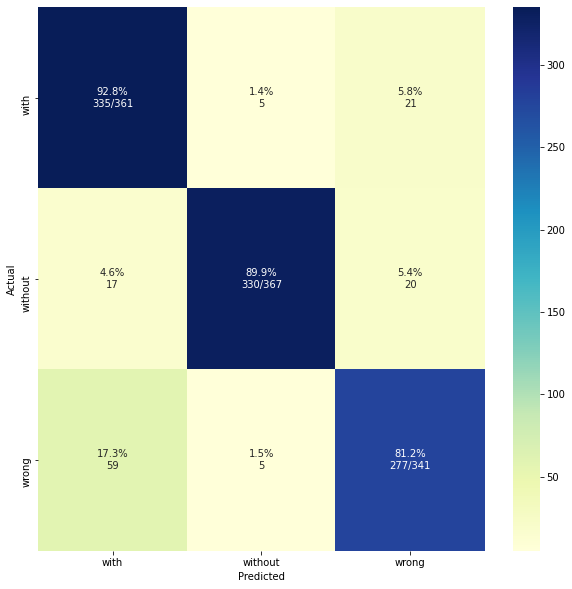

In [ ]:
plot_cm(y_true, y_pred_st,t)

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_test, to_file='model_plot.png', show_shapes=True, expand_nested=False,
show_layer_names=True)

In [ ]:
model_test.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________